## Overview

#### In this module we will learn:

- Principle behind exponential smoothing for time series forecasting
- The mathematics which defines simple exponential smoothing
- How to implement it in practice 
- Extensions including Holt's linear model and Holt-Winters 


## Exponential Smoothing

#### What is it? 

Proposed in the late 1950s, exponential smoothing denotes a group of forecasting methods which rely on a fairly simple principle - we use weighted averages of past observations, with the weights decaying exponentially as the observations get older. Therefore, more recent observations "count more" towards the final prediction. 


#### Why is it so useful? 

- Unlike other statistical approaches, for exponential smoothing we do not need to know the statistical distribution of the data to make a forecast. 
- It generates reliable forecasts quickly and applies easily to a lot of types of time series which makes it extremely useful in practice. 
- Flexible methods of increasing complexity allow you to adapt to depending of the components of the time series. For example, we can add in seasonal components and choose how these are handled. 



### Our data

For this notebook we will use historical stock data for Apple and Amazon. 

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import (
    ExponentialSmoothing,
    SimpleExpSmoothing,
)
from statsmodels.tsa.seasonal import seasonal_decompose

In [41]:
# Download historical stock data from https://www.nasdaq.com/market-activity/stocks/aapl/historical
AAPL = pd.read_csv("data/HistoricalData_AAPL.csv")
AAPL.head()

,Date,Close/Last,Volume,Open,High,Low
0,12/15/2023,$197.57,128538400,$197.53,$198.3999,$197.00
1,12/14/2023,$198.11,66831570,$198.02,$199.62,$196.16
2,12/13/2023,$197.96,70404180,$195.09,$198.00,$194.85
3,12/12/2023,$194.71,52696900,$193.08,$194.72,$191.721
4,12/11/2023,$193.18,60943700,$193.11,$193.49,$191.42


In [42]:
AMZN = pd.read_csv("data/HistoricalData_AMZN.csv")
AMZN.head()

,Date,Close/Last,Volume,Open,High,Low
0,12/15/2023,$149.97,110089300,$148.38,$150.57,$147.88
1,12/14/2023,$147.42,58400850,$149.93,$150.54,$145.52
2,12/13/2023,$148.84,52766200,$148.12,$149.46,$146.82
3,12/12/2023,$147.48,44944260,$145.52,$147.50,$145.30
4,12/11/2023,$145.89,50907290,$145.66,$146.19,$143.64


In [43]:
## Apple
AAPL["Date"] = pd.to_datetime(AAPL["Date"])
AAPL = AAPL.sort_values("Date", ascending=True)
AAPL = AAPL.set_index("Date")
AAPL["Open"] = AAPL["Open"].str.replace("$", "", regex=False).astype("float")
time_seriesAAPL = AAPL["Open"].asfreq("B").ffill()

## Amazon
AMZN["Date"] = pd.to_datetime(AMZN["Date"])
AMZN = AMZN.sort_values("Date", ascending=True)
AMZN = AMZN.set_index("Date")
AMZN["Open"] = AMZN["Open"].str.replace("$", "", regex=False).astype("float")
time_seriesAMZN = AMZN["Open"].asfreq("B").ffill()

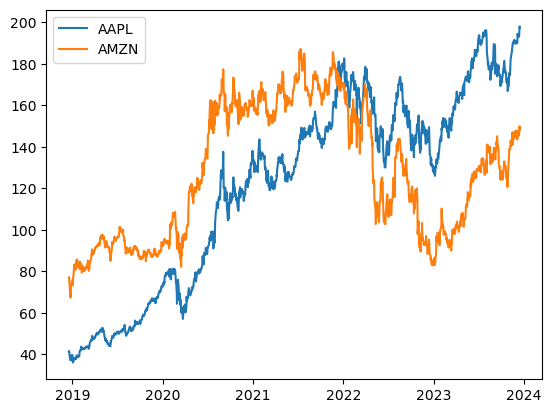

In [44]:
plt.figure()
plt.plot(time_seriesAAPL)
plt.plot(time_seriesAMZN)
plt.legend(["AAPL", "AMZN"])

## Forecasting

Let's build out some simple examples of how we could create a forecast to provide some motivation for exponential smoothing. 


#### Naive Method 1: 

One of the simplest approach to forecasting is that all future values are the same as the last value observed. 

$$
\hat{y}_{T+h} = y_T,
$$
for $h = 1, 2, 3, \ldots$ and where the $\hat{}$ symbol is used to denote an estimated value.

So our forecast would look like a straight, horizontal line continuing on from the last point.

We could think of this as creating a weighted average of observed times, where all of the weight is given to the most recent observation. See https://otexts.com/fpp3/ses.html for more.


/var/folders/pv/t6tzg3zn4nj1ssyv4c1v9pzw0000gn/T/ipykernel_95636/30871903.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  naive_forecast1 = [time_seriesAAPL[-1]] * h


Text(0.5, 1.0, 'A Naive Forecast')

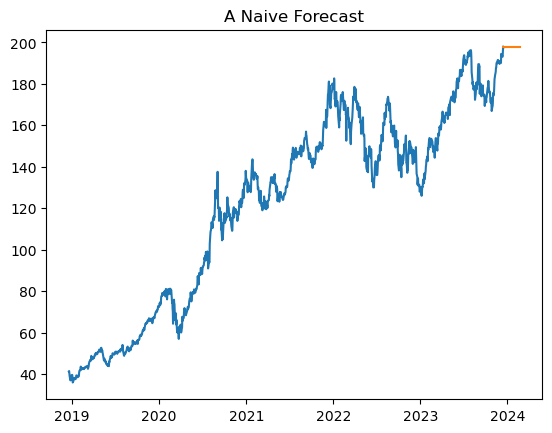

In [45]:
h = 50
forecast_dates = pd.date_range(AAPL.index[-1], periods=h, freq="B")
naive_forecast1 = [time_seriesAAPL[-1]] * h

plt.figure()
plt.plot(time_seriesAAPL)
plt.plot(forecast_dates, naive_forecast1)
plt.title("A Naive Forecast")

#### Naive Method 2: 

Another approach is to again use a weighted average, but this time give all previous observed values the same weight. This is 

$$
\hat{y}_{T+h} = \frac{1}{T} \sum_{t=1}^{T} y_t,
$$
for $h = 1, 2, 3, \ldots$.

Text(0.5, 1.0, 'A Naive Forecast')

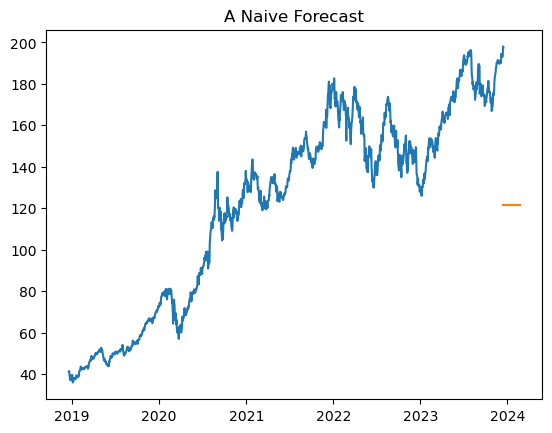

In [46]:
h = 50
forecast_dates = pd.date_range(AAPL.index[-1], periods=h, freq="B")
naive_forecast2 = [time_seriesAAPL.mean()] * h

plt.figure()
plt.plot(time_seriesAAPL)
plt.plot(forecast_dates, naive_forecast2)
plt.title("A Naive Forecast")

#### Is there something in between these two extreme approaches?

One sensible approach to weighting past observations is to attach larger weights to more recent observations, and smaller weights to behaviour from the distant past. 

$$
\hat{y}_{T+1} = \alpha y_T + \alpha (1 - \alpha) y_{T-1} + \alpha (1 - \alpha)^2 y_{T-2} + \ldots
$$
where $0 \leq \alpha \leq 1$ is the smoothing parameter. 

Therefore the rate at which the weights decrease is controlled by the parameter $\alpha$. If $\alpha$ is small (i.e., close to 0), more weight is given to observations from the more distant past. If $\alpha$ is large (i.e., close to 1), more weight is given to the more recent observations. 

Note that when $\alpha = 1$ then $y_{T+1} = y_T$ and the forecasts are the same as our Naive Method 1. 

This framework forms the basis for Simple Exponential Smoothing.

## Simple Exponential Smoothing (SES)

Simple exponential smoothing is the simplest of the exponential smoothing methods. It is most useful for data that shows no clear trend or seasonal component. For example, you may choose to do a time series decomposition and apply this method on the remaining residuals. 

(We will discuss later how more complex exponential smoothing models handle trend and seasonality)


#### How does it work? 


We can write the equation from above more succinctly as

$$
\hat{y}_{T+1} = \alpha y_{T} + (1 - \alpha) \hat{y_T},
$$

so in general for any timepoint $t$

$$
\hat{y}_{t+1} = \alpha y_{t} + (1 - \alpha) \hat{y_t}.  
$$


This means that the one-step ahead forecast of $y$ is a weighted combination of the last known observation $y_t$ and the last estimate, calculated using times up until $t-1$. 


This is a recursive setup which just requires us to have an initial estimated value, which we call $l_0$. That is we start with 

$$
\hat{y}_{2} = \alpha y_{1} + (1 - \alpha) l_0,
$$
using $l_0 := \hat{y_1}$. 

Then we can proceed by consecutively substituting in the next estimate into our general equation for $\hat{y}_{t+1}$.

### The component form

An alternative way of writing SES is using the component form. This is very useful as it expresses the above equations in terms of the level (a smoothed value of the time series at a given time), and in more complex models, also the trend and seasonal components. 

For SES, the component form uses two equations, being a forecast equation and a level equation which together provide a model for the data. 

The forecast equation expresses each of the components of the model, being a just a flat level in the case of SES. When trend and seasonal components are included, these can simply be added to the forecast equation. 

The level equation provides estimated level of the series at each time $t$.




Forecast equation:

$$
\hat{y}_{t+h} = l_t
$$

Level equation: 

$$
l_t = \alpha y_{t} + (1-\alpha) l_{t-1}
$$


Notice that if we substitute the level equation into the forecast equation, we end up with the same form we saw before. 

Now if we had a time series of length $T$, we could substitute $T$ in for $t$ and use this to make forecasts of length $h$. 

Let's see an example of this working!

First, because with SES we assume there is no trend or seasonality, we could remove it from our time series using a decomposition.

In [47]:
def ts_decompose(y, model="additive", period=52):
    result = seasonal_decompose(y, model=model, period=52)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, "k", label="Original " + model)
    axes[0].legend(loc="upper left")

    axes[1].plot(result.trend, label="Trend")
    axes[1].legend(loc="upper left")

    axes[2].plot(result.seasonal, "g", label="Seasonality:")
    axes[2].legend(loc="upper left")

    axes[3].plot(result.resid, "r", label="Residuals:")
    axes[3].legend(loc="upper left")
    plt.show(block=True)
    return result

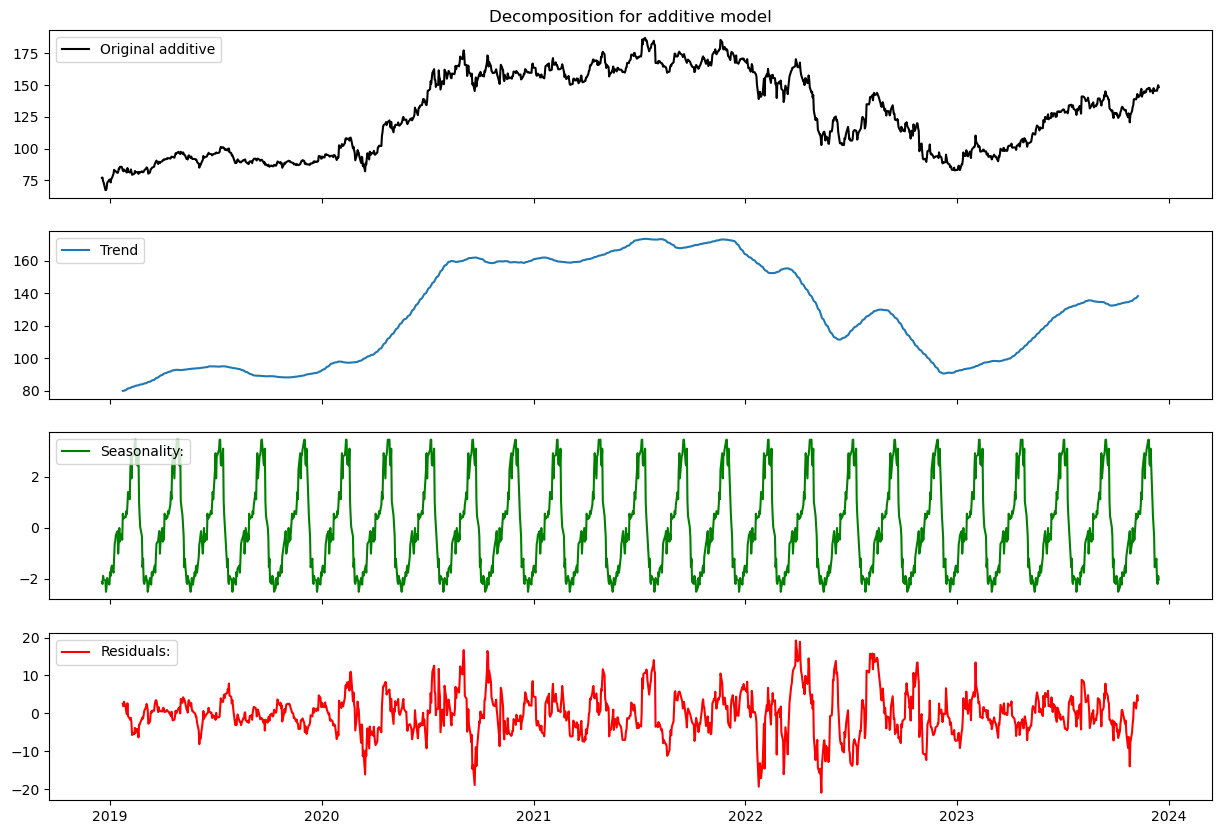

In [48]:
result = ts_decompose(
    time_seriesAMZN,
    period=52,
)

Now we could use a SES model for the residual component, and separately account for any trend behaviour. To do this, we need to think about parameter selection.

## Parameter selection

In practice, we need to set a value for our smoothing parameter $\alpha$ and our initial value for the level, $l_0$. 

Python's exponential smoothing functions can handle this for us, however what's happening under the hood?

In some cases, the smoothing parameters may be user selected and set based on previous experience. However, a more reliable and objective way to obtain values for the unknown parameters is to estimate them from the observed data. To estimate them, we use an almost identical approach to our optimal parameter selection in regression models; that is we minimize error. 

$$
{\rm{SSE}} = \sum_{t=1}^T \left( y_t - \hat{y_t} \right)^2
$$

This is a non-linear minimisation problem can be solved with an optimization tool.

## SES model with SimpleExpSmoothing 

In [49]:
# split the data to a training and test set
train = time_seriesAMZN[:-200]
test = time_seriesAMZN[-200:]

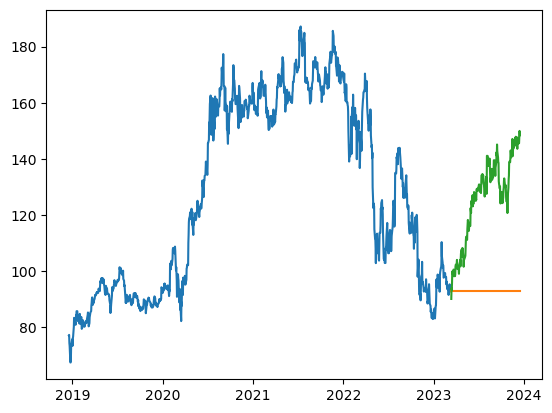

In [50]:
ses_model = SimpleExpSmoothing(train).fit()
y_pred = ses_model.forecast(len(test))

plt.figure()
plt.plot(train)
plt.plot(test.index, y_pred)
plt.plot(test)

As we can see, the SES model produces a flat forecast with the parameters being estimated by the SimpleExpSmoothing function. To improve this model, we clearly need to include a trend aspect, given our data

## Holt's Linear Trend Method (also known as Double Exponential Smoothing, DES)

Here we will show one extension of SES to account for a linear trend. A similar extension can additionally include a seasonality component (a model called Holt-Winters). 


We saw that SES is intended for data without a trend or any seasonal components, however it is fairly simple to extend SES to account for linear trend using the component form of the equations. Now we have three equations, one for the forecast, one for the level, and an additional form for the trend.


Forecast equation:

$$
\hat{y}_{t+h} = l_t + hb_t
$$

Level equation: 

$$
l_t = \alpha y_{t} + (1-\alpha) (l_{t-1} + b_{t-1})
$$ 

Trend equation: 

$$
b_t = \beta^* (l_{t} - l_{t-1}) + (1- \beta^*) b_{t-1}.
$$ 


Whilst this looks like a lot at first we can decompose these to understand how each component works. Recall that 




1. The forecast equation:
    This is similar to the equation used for SES, however now we have an additive trend. The $h$ coefficient is the number of units of time we want to forecast and $b_t$ gives us the trend at time $t$. 
    
    
2. The level equation:
    Here we have an almost identical equation to with SES. The only difference is that here we add in a trend component to our weighted average so that we are using the one-step ahead training forecast. 
    
    
3. The trend equation:
    In the same form as the level equation, we take a weighted average of the estimated trend at time $t$ and the previous estimate, $b_{t-1}$.
    


## DES model with ExponentialSmoothing

Recall again our train and test data for our Amazon stock. 

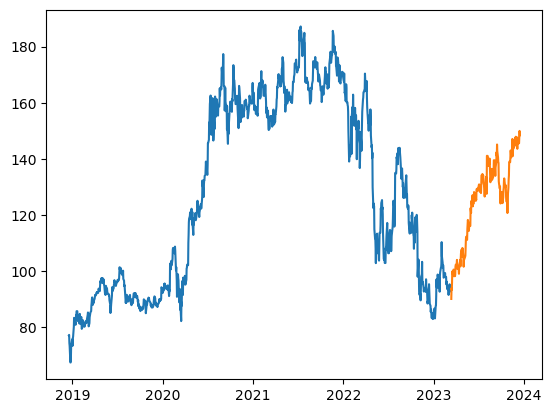

In [51]:
plt.figure()
plt.plot(train)
plt.plot(test)

We can now fit a DES/Holt's linear model to the data. We can either use the built-in optimizer for the parameters, or we can specify them ourself. 

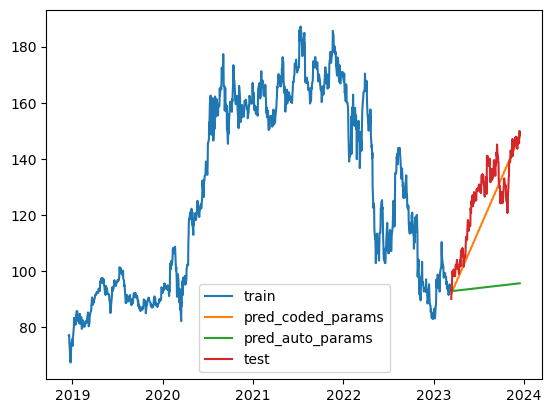

In [52]:
des_model1 = ExponentialSmoothing(train, trend="add").fit(
    smoothing_level=0.1, smoothing_trend=0.5
)
des_model2 = ExponentialSmoothing(
    train, trend="add", initialization_method="estimated", damped_trend=False
).fit()

y_pred1 = des_model1.forecast(len(test))
y_pred2 = des_model2.forecast(len(test))

plt.figure()
plt.plot(train)
plt.plot(test.index, y_pred1)
plt.plot(test.index, y_pred2)
plt.plot(test)
plt.legend(["train", "pred_coded_params", "pred_auto_params", "test"])

In this case, when we compare the test data with our hard coded parameters, we se that our coded ones perform better. Therefore it can be worthwhile exploring both options and cross-validating. 

In the practical, we will also explore accounting for seasonal components using the `ExponentialSmoothing` function.

## Apple data

Let's explore the same model on the AAPL stock data

In [53]:
# split the data to a training and test set
train = time_seriesAAPL[:-200]
test = time_seriesAAPL[-200:]

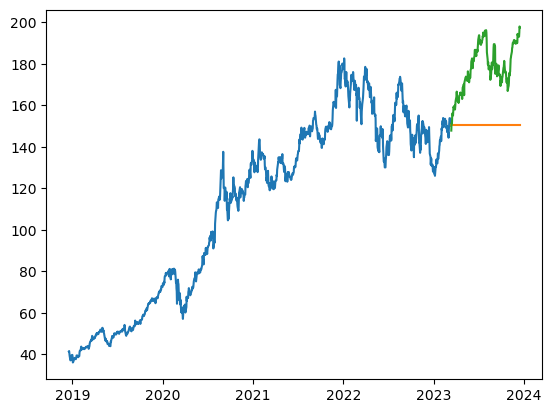

In [54]:
ses_model = SimpleExpSmoothing(train).fit()
y_pred = ses_model.forecast(len(test))

plt.figure()
plt.plot(train)
plt.plot(test.index, y_pred)
plt.plot(test)

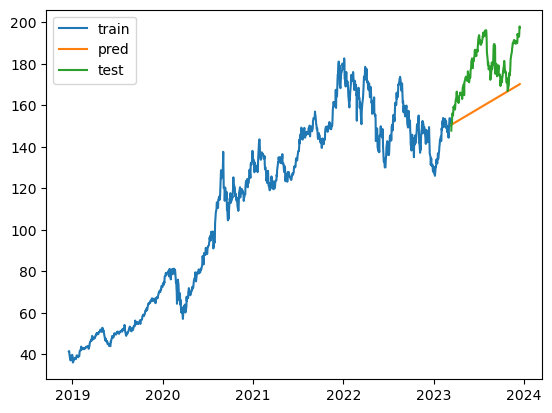

In [55]:
# now let's try a DES model
des_model = ExponentialSmoothing(
    train, trend="add", initialization_method="estimated", damped_trend=False
).fit()

y_pred = des_model.forecast(len(test))

plt.figure()
plt.plot(train)
plt.plot(test.index, y_pred)
plt.plot(test)
plt.legend(["train", "pred", "test"])

There are many other useful parameters within the function including:

- damped_trend: boolean which allows for the trend effect to dampen over a forecast
- use_boxcox: automatically apply the Box-Cox transformation to the data
- missing: how to handle missing values
- seasonal: type of seasonal component to include